<a href="https://colab.research.google.com/github/g-nightingale/misc-analysis/blob/master/covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Covid-19 analysis
**Author:** Geoff Nightingale <br>
**Date:** March 2020 <br>
**Purpose:** View basic covid-19 trends and stats

In [1]:
import urllib.request, json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters for charting
min_deaths = 100
period = 3

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Extract data
def get_data():
  with urllib.request.urlopen("https://pomber.github.io/covid19/timeseries.json") as url:
      covid_json = json.loads(url.read().decode())

  # Build DataFrame
  total_df = pd.DataFrame()
  first = True
  for k, v in covid_json.items():
      tmp_df = pd.DataFrame(v)
      tmp_df['country'] = k
      tmp_df['date_fixed'] = tmp_df['date'].str[:4].astype(int) * 10000 \
                           + tmp_df['date'].str[5:6].astype(int) * 100 \
                           + tmp_df['date'].str[7:].astype(int)

      if first is True:
        total_df = tmp_df
        first = False
      else:
        total_df = pd.concat([total_df, tmp_df], axis=0)

  total_df.sort_values(['country','date_fixed'], ascending=[True, True], inplace=True)
  total_df.reset_index(drop=True, inplace=True)

  return total_df

total_df = get_data()

In [3]:
# Check totals
total_df.groupby('country').agg({'confirmed':'max', 'deaths':'max'}).sort_values('deaths', ascending=False)[:20]

,confirmed,deaths
country,,
US,1699176,100418
United Kingdom,268619,37542
Italy,231139,33072
Spain,236259,28752
France,183067,28599
Brazil,411821,25598
Belgium,57592,9364
Mexico,78023,8597
Germany,181524,8428


In [4]:
# Create DataFrame from point of time where defined deaths first recorded
index_var = 'days_since_first_' + str(min_deaths) + '_deaths'

total_df['count'] = np.where(total_df['deaths']>=min_deaths, 1, 0)
total_df[index_var] = total_df.groupby(['country'])['count'].cumsum()
total_df['deaths_new'] = total_df.groupby(['country'])['deaths'].diff(periods=1)
total_df['deaths_l' + str(period) + 'd'] = total_df.groupby(['country'])['deaths_new'].rolling(window=period, min_periods=period).mean().reset_index(drop=True)
total_df['deaths_l' + str(period) + 'd_lag'] = total_df['deaths_l' + str(period) + 'd'].shift(periods=period)
total_df['deaths_l' + str(period) + 'd_ratio'] = total_df['deaths_l' + str(period) + 'd'] / total_df['deaths_l' + str(period) + 'd_lag']
total_df2 = total_df[total_df[index_var]>0].reset_index(drop=True)

total_df2

,date,confirmed,deaths,recovered,country,date_fixed,count,days_since_first_100_deaths,deaths_new,deaths_l3d,deaths_l3d_lag,deaths_l3d_ratio
0,2020-5-6,3392,104,458,Afghanistan,20200506,1,1,9.0,6.333333,7.000000,0.904762
1,2020-5-7,3563,106,468,Afghanistan,20200507,1,2,2.0,5.333333,7.333333,0.727273
2,2020-5-8,3778,109,472,Afghanistan,20200508,1,3,3.0,4.666667,7.666667,0.608696
3,2020-5-9,4033,115,502,Afghanistan,20200509,1,4,6.0,3.666667,6.333333,0.578947
4,2020-5-10,4402,120,558,Afghanistan,20200510,1,5,5.0,4.666667,5.333333,0.875000
...,...,...,...,...,...,...,...,...,...,...,...,...
3160,2020-5-23,258504,36757,1149,United Kingdom,20200523,1,67,282.0,323.666667,356.666667,0.907477
3161,2020-5-24,260916,36875,1151,United Kingdom,20200524,1,68,118.0,250.333333,416.000000,0.601763
3162,2020-5-25,262547,36996,1161,United Kingdom,20200525,1,69,121.0,173.666667,351.000000,0.494777
3163,2020-5-26,266599,37130,1161,United Kingdom,20200526,1,70,134.0,124.333333,323.666667,0.384140


In [5]:
# Check counts
total_df2['country'].value_counts()

China              121
Italy               85
Iran                84
Spain               76
France              73
                  ... 
Kuwait              12
North Macedonia     11
Sudan               10
Australia            9
Croatia              3
Name: country, Length: 69, dtype: int64

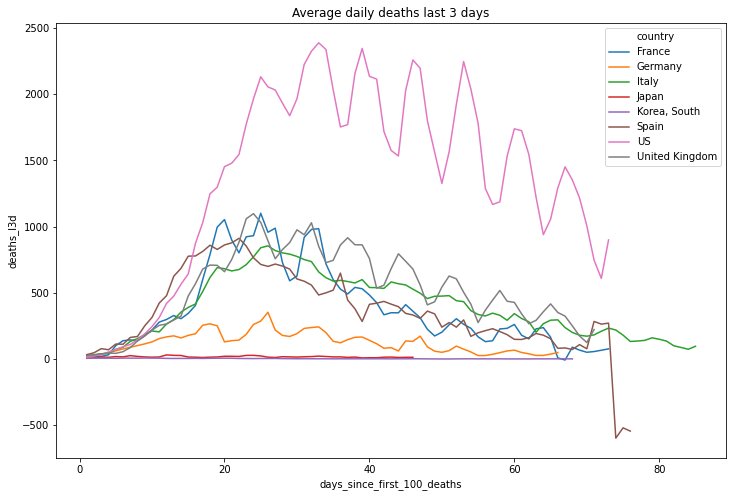

In [6]:
# Plot data of average daily deaths since first x number of deaths recorded
country_list = ['Italy', 'Spain', 'France', 'US', 'United Kingdom', 'Korea, South', 'Japan', 'Germany', 'NZ']

filtered_df = total_df2[total_df2['country'].isin(country_list)]

plt.figure(figsize=(12, 8))
plt.title('Average daily deaths last ' +str(period) +  ' days')
sns.lineplot(x=index_var, y='deaths_l' + str(period) + 'd', hue='country', data=filtered_df,
             markers=True)
plt.show()

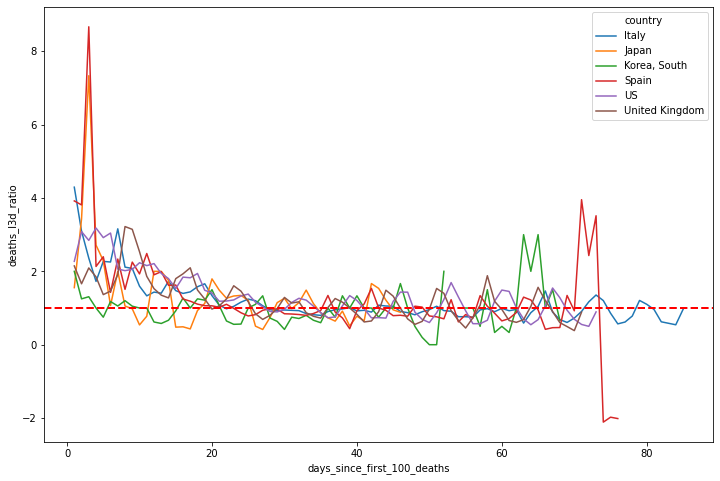

In [7]:
# Plot ratio of deaths in last 0 - z days vs last  z - 2z days
country_list = ['Italy', 'Spain', 'US', 'United Kingdom', 'Korea, South', 'Japan']

filtered_df = total_df2[total_df2['country'].isin(country_list)]

plt.figure(figsize=(12, 8))
sns.lineplot(x='days_since_first_' + str(min_deaths) + '_deaths', y='deaths_l' + str(period) + 'd_ratio', hue='country', data=filtered_df,
             markers=True)
plt.axhline(1.0, color='red', linestyle='dashed', linewidth=2)
plt.show()

In [8]:
# Check data for UK
total_df[total_df['country']=='United Kingdom']

,date,confirmed,deaths,recovered,country,date_fixed,count,days_since_first_100_deaths,deaths_new,deaths_l3d,deaths_l3d_lag,deaths_l3d_ratio
22606,2020-1-22,0,0,0,United Kingdom,20200122,0,0,NaN,NaN,2.333333,NaN
22607,2020-1-23,0,0,0,United Kingdom,20200123,0,0,0.0,NaN,3.000000,NaN
22608,2020-1-24,0,0,0,United Kingdom,20200124,0,0,0.0,NaN,3.333333,NaN
22609,2020-1-25,0,0,0,United Kingdom,20200125,0,0,0.0,0.000000,NaN,NaN
22610,2020-1-26,0,0,0,United Kingdom,20200126,0,0,0.0,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
22728,2020-5-23,258504,36757,1149,United Kingdom,20200523,1,67,282.0,323.666667,356.666667,0.907477
22729,2020-5-24,260916,36875,1151,United Kingdom,20200524,1,68,118.0,250.333333,416.000000,0.601763
22730,2020-5-25,262547,36996,1161,United Kingdom,20200525,1,69,121.0,173.666667,351.000000,0.494777
22731,2020-5-26,266599,37130,1161,United Kingdom,20200526,1,70,134.0,124.333333,323.666667,0.384140


In [0]:
# Export to csv
total_df.to_csv('check.csv')